In [75]:
%load_ext autoreload
%autoreload 2
from naplab import process_frame, parse_camera_json, filter_cameras, get_test_data, normalize
from utils import plot_coordinates, plot_directions
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
cameraList = parse_camera_json("./Trip094/camerasandCanandGnssCalibratedAll_lidars00-virtual.json")
c3_120 = filter_cameras(cameraList, ["C3_tricam120"])[0]
c5_r1, c7_l2 = filter_cameras(cameraList, ["C5_R1", "C7_L2"])
data = get_test_data("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt")
#data = process_frame("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt")

In [77]:
# Note that the x-axis is for forwards and backwards while the y-axis is for left/right,
#print(c7_l2.translation)
#print(c5_r1.translation)
c5_r1.get_camera_intrinsics()#, c5_r1.video_path, c5_r1.timestamps

{'camera_model': 'OPENCV',
 'fl_x': 1662.7687752661222,
 'fl_y': 1046.158687771602,
 'cx': 965.822693,
 'cy': 649.506042,
 'w': 1920,
 'h': 1208,
 'k1': 0.9165923647368714,
 'k2': -0.05700684382836211,
 'k3': 0.016865157009512344,
 'k4': -0.004610156538900732,
 'p1': 0,
 'p2': 0}

In [78]:
c5_r1.get_colmap_camera_description()

'4 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 965.822693 649.506042 0.9165923647368714 -0.05700684382836211 0.016865157009512344 -0.004610156538900732'

In [79]:
for camera in cameraList:
    print(camera.get_colmap_camera_description())

0 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 846.863159 670.665466 1.7745531453906678 -0.08552534951863729 0.5676196293021356 -0.8683830303445993
1 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 1187.267212 632.114624 1.8129401914064291 -0.04701288763945396 0.2975290615205834 -0.3466824045471046
2 OPENCV_FISHEYE 1920 1208 554.2562584220409 348.71956259053405 978.875977 650.693054 2.869133954671687 -0.26555815488423784 0.09966393948697028 -0.02472800733634628
3 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 962.005554 643.866516 0.9218197289547588 -0.06102188862424611 0.020014356394618776 -0.005940672159719638
4 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 965.822693 649.506042 0.9165923647368714 -0.05700684382836211 0.016865157009512344 -0.004610156538900732
5 OPENCV_FISHEYE 1920 1208 1662.7687752661222 1046.158687771602 977.374146 644.835571 0.9311890807430251 -0.05684095384396466 0.01096238952566873 -0.0024086688187029

In [80]:
# test the translation and rotation matrix
epsilon = 0.0001
points = [frame.center for frame in data]

points_from_translation_matrix = [frame.get_translation_matrix() @ np.array([0,0,0,1]) for frame in data]
diffs = np.stack(points) - np.stack(points_from_translation_matrix)
max_error = np.max(diffs)

if max_error > epsilon:
    raise Exception("Car translation matrix broken")

points = np.stack(points)
norms = np.linalg.norm(points, axis=-1)

points_from_rotated_norms = [frame.get_rotation_matrix() @ (np.array([1,1/4,0,1]) * norm) for (frame, norm) in zip(data, norms)]
diffs = np.stack(points_from_rotated_norms) - points
max_error = np.max(diffs)

if max_error > epsilon:
    print("Test failed: Rotated point does not match expected point.")
    print(f"Max error: {max_error}")

Test failed: Rotated point does not match expected point.
Max error: 7045282.588193032


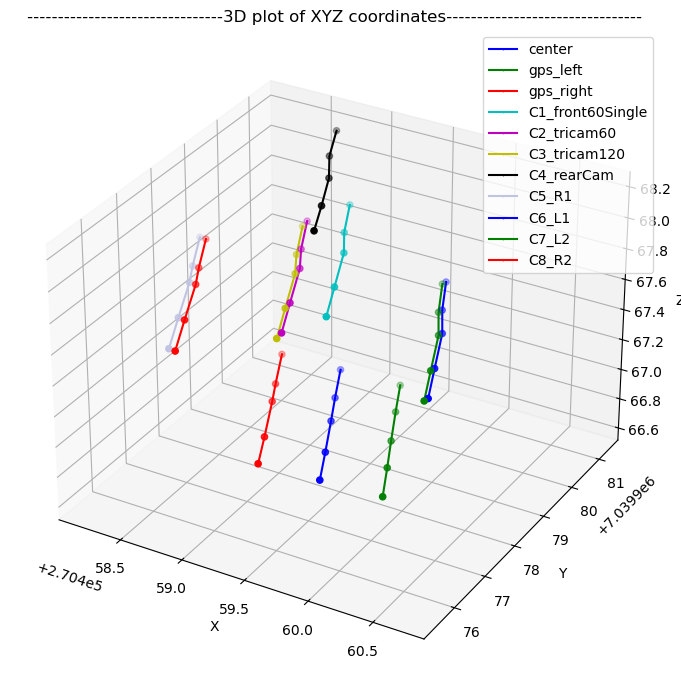

In [81]:
max_index = 5

gps_left = [frame.left_point for frame in data]
gps_right = [frame.right_point for frame in data]
center = [frame.center for frame in data[:max_index]]

cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[:max_index]]

cam_positions = []
for camera in cameraList:
    cam_positions.append([camera.get_camera_position(frame) for frame in data[:max_index]])

#cam_positions = [camera.get_camera_position(frame) for frame in data[:max_index] for camera in cameraList]
#print(cam_positions[0])
cam_labels = [camera.description for camera in cameraList]

plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index], *cam_positions], 
        labels=["center", "gps_left", "gps_right", *cam_labels], figsize=(7, 7), is3D=True)
#plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index]], 
#        labels=["center", "gps_left", "gps_right"], figsize=(7, 7), is3D=False)
#plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index]], 
#        labels=["center", "gps_left", "gps_right"], figsize=(7, 7), is3D=False)



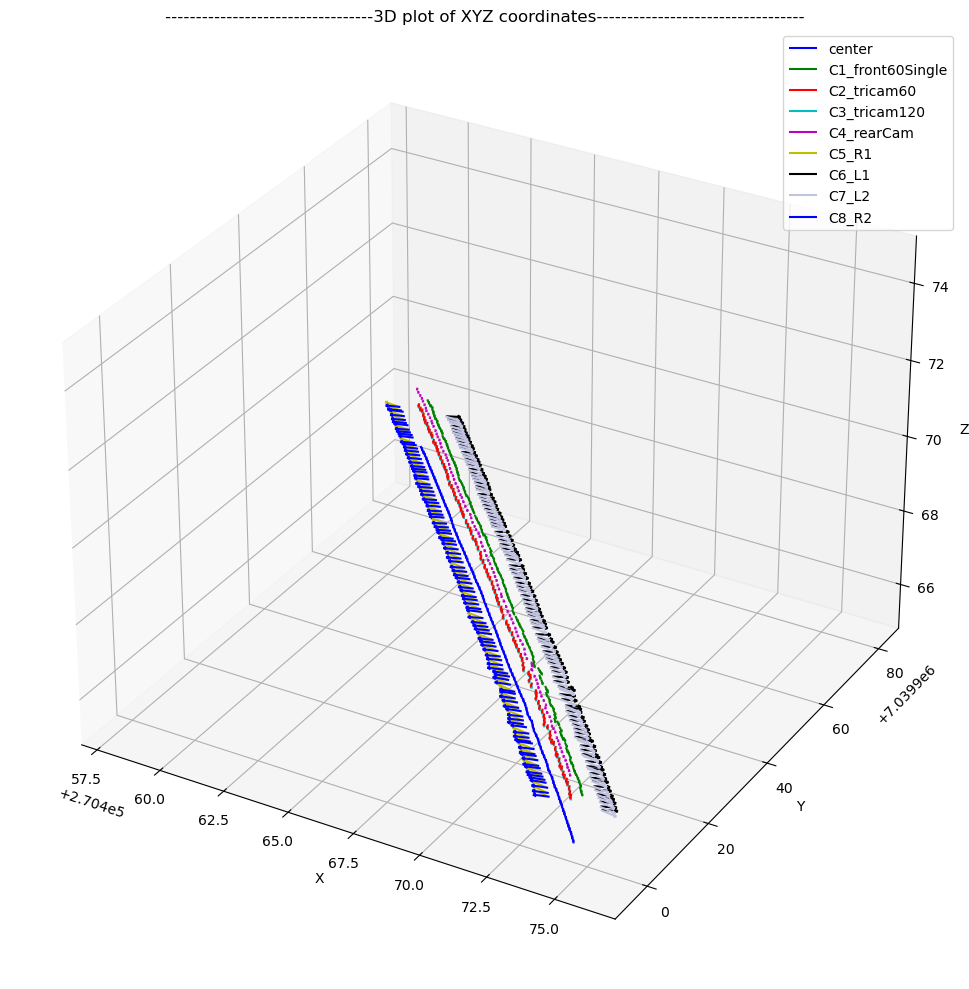

In [82]:
min_index = 0
max_index = 100
center = [frame.center for frame in data[min_index:max_index]]
cardir = [frame.get_rotation_matrix() @ np.array([1,0,0,1]) for frame in data][min_index:max_index]
cardir2 = [frame.forward for frame in data][min_index:max_index]
carup = [frame.up for frame in data[min_index:max_index]]
dir1 = [c5_r1.get_camera_direction_vector(frame) for frame in data][min_index:max_index]
dir2 = [c7_l2.get_camera_direction_vector(frame) for frame in data][min_index:max_index]

cam_dirs = []
for camera in cameraList:
    cam_dirs.append([camera.get_camera_direction_vector(frame) for frame in data[min_index:max_index]])

cam_positions = []
for camera in cameraList:
    cam_positions.append([camera.get_camera_position(frame) for frame in data[min_index:max_index]])

cam_labels = [camera.description for camera in cameraList]

cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[min_index:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[min_index:max_index]]

directions = [cardir, *cam_dirs]
#directions = [cardir, carup]
positions = [center, *cam_positions]
#positions = [center, center]
labels = ["center", *cam_labels]
plot_directions(positions, directions, labels, figsize=(10, 10), is3D=True)


In [120]:
from naplab.frame_data import better_process_data


#timestamps = cameraList[0].timestamps
#data = better_process_data("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt", timestamps)


full_str = ""
total_offset = 0
for cam in cameraList:
    timestamps = cam.timestamps
    data = better_process_data("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt", timestamps)[:20]
    fis = [timestamps.index(frame.timestamp) for frame in data]
    cam.save_frames(fis)
    next_str, offset = cam.get_colmap_image_txt(total_offset, data)
    total_offset += offset
    full_str += next_str
with open("test.txt", "w") as f:
    f.write(full_str)